In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, compile
from qiskit.tools.visualization import plot_histogram

In [49]:
hash_bits = 3
goal_hashed_value = [1, 0, 1]

# Parameters of the hash function
# Step one: for any True element, invert the coresponding qbit
hash_negation = [True, False, False]
# Step two: each element is the index of of the qbit, pre-scramble 
hash_scramble = [1, 2, 0]

In [50]:
# Set all input registers to |+> superposition
def initialize_input_registers(circuit, input_registers):
    for i in range(hash_bits):
        circuit.h(input_registers[i])

In [51]:
# Entangle the output_register to show when the input_register superposition matches the goal_hash_value
def build_oracle(quantum_circuit, input_registers, output_register, auxiliary_register):
    
    # For any bit that is negatated, add a "x" flip to do so
    for (i, negate) in enumerate(hash_negation):
        if negate:
            quantum_circuit.x(input_registers[i])

    # Apply the scramble instructions to the input registers
    scrambled_input_registers = [0] * hash_bits
    for i in hash_scramble:
        scrambled_input_registers[i] = input_registers[hash_scramble[i]]

        # Flip any bits for which the goal is 0, so we can have a sucessful match if all bits are 1s
    for (i, goal_value) in enumerate(goal_hashed_value):
        if goal_value == 0:
            quantum_circuit.x(scrambled_input_registers[i])
    
    # Flag the output register for any superpositions that are now all 1s
    # Currenty this part handles only a 3 bit hash - a CCCNOT gate
    quantum_circuit.ccx(scrambled_input_registers[0], scrambled_input_registers[1], auxiliary_register[0])
    quantum_circuit.ccx(scrambled_input_registers[2], auxiliary_register[0], output_register[0])
    
    # Pull the auxiliary_register out of superposition
    quantum_circuit.ccx(scrambled_input_registers[0], scrambled_input_registers[1], auxiliary_register[0])

    # un(re)flip any bits that were flipped to match 0s
    for (i, goal_value) in enumerate(goal_hashed_value):
        if goal_value == 0:
            quantum_circuit.x(scrambled_input_registers[i])
    
    # Unscramble the bits, we'll just go back to using input_registers
    
    # un(re)flip any bits that were negated by the hash function
    for (i, negate) in enumerate(hash_negation):
        if negate:
            quantum_circuit.x(input_registers[i])


In [52]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function

In [53]:
def inversion_about_average(circuit, input_registers):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    for j in range(hash_bits):
        circuit.h(input_registers[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(hash_bits):
        circuit.x(input_registers[j])
    n_controlled_Z(circuit, [input_registers[j] for j in range(hash_bits-1)], input_registers[hash_bits-1])
    for j in range(hash_bits):
        circuit.x(input_registers[j])
    # Hadamards everywhere again
    for j in range(hash_bits):
        circuit.h(input_registers[j])
# -- end function

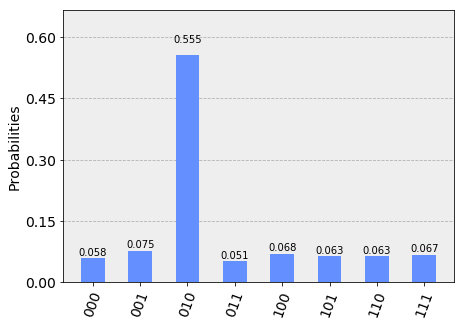

In [70]:
# Create our qubits
input_registers = QuantumRegister(hash_bits)
output_register = QuantumRegister(1)
auxiliary_register = QuantumRegister(1)

# Create a space to store measured results
result_registers = ClassicalRegister(hash_bits)

# Define quantum circuit with above registers
grover = QuantumCircuit()
grover.add_register(input_registers)
grover.add_register(output_register)
grover.add_register(auxiliary_register)
grover.add_register(result_registers)

# Set all starting qubits into |+> superposition
initialize_input_registers(grover, input_registers)

# Add loops of the oracle and inversion
for t in range(2):
    build_oracle(grover, input_registers, output_register, auxiliary_register)
    inversion_about_average(grover, input_registers)

# Add measurements of the input cubits to the result registers
# This collapses the wave function
for i in range(hash_bits):
    grover.measure(input_registers[i], result_registers[i])

# Execute the algorithm
backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=1000)
result = job.result()

# Get counts and plot a historgam of the frequency of value of each qubit
counts = result.get_counts(grover)
plot_histogram(counts)